# Pricing of one-arm bandit

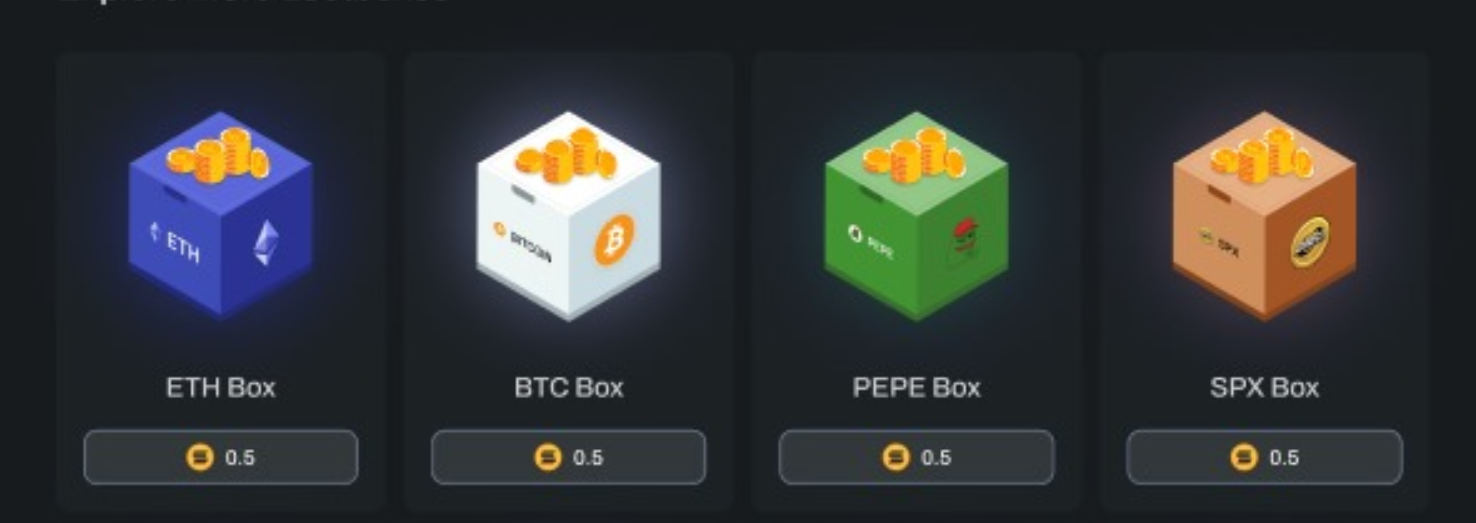

## Imports & utils

In [6]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import optuna
from pydantic import PositiveFloat

from IPython.core.magic import register_cell_magic


@register_cell_magic
def skip(line, cell):
    return


warnings.simplefilter(action="ignore", category=FutureWarning)


def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)


set_seed(2)

## Quantitative pricing 

### A. Analytics

1. **Probability Sum**:

$$
p_{\text{BTC}} + p_{\text{ETH}} + p_{\text{SOL}} + p_{\text{trashy}} = 1
$$

2. **Expected Value Condition**:

$$
p_{\text{BTC}} \cdot \text{BTC} + p_{\text{ETH}} \cdot \text{ETH} + p_{\text{SOL}} \cdot \text{SOL} + p_{\text{trashy}} \cdot \text{trashy} = 0.95 \cdot \text{spin price}
$$

### B. Optimization study

The constrained optimization problem:

In [7]:
"""Naive implementation does not work, use softmax instead!!!
    SO DO NOT TRY DIRECT CONSTRAINED SAMPLING!!!
    p_BTC = trial.suggest_float("p_BTC", 0, 1)
    p_ETH = trial.suggest_float("p_ETH", 0, 1 - p_BTC)
    p_SOL = trial.suggest_float("p_SOL", 0, 1 - p_BTC - p_ETH)
    p_trashy = 1 - p_BTC - p_ETH - p_SOL
"""
def objective(
    trial,
    BTC: PositiveFloat,
    ETH: PositiveFloat,
    SOL: PositiveFloat,
    trashy: PositiveFloat,
    spin_price: PositiveFloat,
):
    logits = [
    trial.suggest_float(f"logit_{i}", -10, 10) for i in range(4)
    ]
    probs = np.exp(logits) / np.sum(np.exp(logits))

    p_BTC, p_ETH, p_SOL, p_trashy = probs

    expected_value = p_BTC * BTC + p_ETH * ETH + p_SOL * SOL + p_trashy * trashy

    target = 0.95 * spin_price

    return abs(expected_value - target)

The study, with 1 billion simulations:

In [8]:
sampler = optuna.samplers.TPESampler(seed=3)
study = optuna.create_study(
    study_name="probabilities_exploration",
    direction="minimize",
    sampler=sampler,
    storage="sqlite:///optuna_db/probs.db",
    load_if_exists=True,
)

#get live data from API, now just a demo... prices quoted in USD

BTC = 99560.17
ETH = 4001.27
SOL = 238.43
trashy = 50 # for the sake of the example, but certainly should be consistently higher than a PEPE COIN
spin_price = SOL/2

spot_price_objective = lambda trial: objective(
    trial, BTC, ETH, SOL, trashy, spin_price
)
#study.optimize(spot_price_objective, n_trials=10**9)

[I 2024-12-08 03:22:28,307] Using an existing study with name 'probabilities_exploration' instead of creating a new one.


... and the best trial:

In [9]:
best_logit_values = [
    study.best_trial.params[f"logit_{i}"] for i in range(4)
]

exp_logits = np.exp(best_logit_values - np.max(best_logit_values))
best_probabilities = exp_logits / np.sum(exp_logits)

p_BTC, p_ETH, p_SOL, p_trashy = best_probabilities

print(f"Total trials", len(study.trials))
print(f"Probability for BTC: {p_BTC:.14f}")
print(f"Probability for ETH: {p_ETH:.14f}")
print(f"Probability for SOL: {p_SOL:.14f}")
print(f"Probability for Trashy asset: {p_trashy:.14f}")

Total trials 40244
Probability for BTC: 0.00000997210931
Probability for ETH: 0.00000254185701
Probability for SOL: 0.33037030610849
Probability for Trashy asset: 0.66961717992519


Let´s perform a stability study of the optimization (top 30 trials):

In [10]:
results = []
sorted_trials = [trial for trial in study.trials if trial is not None]
sorted_trials = [trial for trial in study.trials if trial.value is not None]
sorted_trials = sorted(sorted_trials, key=lambda trial: trial.value)

for idx, trial in enumerate(sorted_trials[:30]):   
    best_logit_values = [
        trial.params[f"logit_{i}"] for i in range(4)
    ]

    exp_logits = np.exp(best_logit_values - np.max(best_logit_values))  # Numerical stability
    best_probabilities = exp_logits / np.sum(exp_logits)

    p_BTC, p_ETH, p_SOL, p_trashy = best_probabilities

    results.append({
        "Trial": idx + 1,
        "BTC Probability": round(p_BTC, 14),
        "ETH Probability": round(p_ETH, 14),
        "SOL Probability": round(p_SOL, 14),
        "Trashy Probability": round(p_trashy, 14),
        "Absolute deviation from expected value": trial.value
    })

df = pd.DataFrame(results)

print(df.to_markdown(index=False))

|   Trial |   BTC Probability |   ETH Probability |   SOL Probability |   Trashy Probability |   Absolute deviation from expected value |
|--------:|------------------:|------------------:|------------------:|---------------------:|-----------------------------------------:|
|       1 |       9.97211e-06 |       2.54186e-06 |          0.33037  |             0.669617 |                              0.000203364 |
|       2 |       2.91898e-06 |       9.33203e-08 |          0.334128 |             0.665869 |                              0.00359742  |
|       3 |       5.37034e-07 |       1.59041e-06 |          0.335346 |             0.664652 |                              0.00536854  |
|       4 |       3.11652e-06 |       3.73893e-06 |          0.333936 |             0.666057 |                              0.00583677  |
|       5 |       8.82229e-06 |       6.44981e-06 |          0.330929 |             0.669055 |                              0.00617244  |
|       6 |       1.01013e-05 |   